In [60]:
import torch
import numpy as np 
from matplotlib import pyplot as plt
import gym

In [61]:
%matplotlib inline

In [62]:
environment_name = "MountainCar-v0"
environment_name = 'CartPole-v0'
dummy_env = gym.make(environment_name)

dummy_env.close
#dummy_env.env.get_action_meanings()
#help(dummy_env.unwrapped)

<bound method Wrapper.close of <TimeLimit<CartPoleEnv<CartPole-v0>>>>

In [63]:
from typing import NamedTuple,List

class EpisodeStep(NamedTuple):
    state: any
    action: int
    reward: float
    is_done: bool

class ActorCriticWrapper(NamedTuple):
    action_tensors: torch.Tensor
    log_probs : torch.Tensor
    critic_value : torch.Tensor


def episode_returns(episode_rewards: List[float]):
    # rewards = Sigma gamma**t * reward[t]
    gamma = 0.90
    discount_factors = np.array([gamma**i  for i in range(len(episode_rewards) )])
    returns = np.array([])

    for i in range(len(episode_rewards)):
        expected_return = np.dot(episode_rewards[i:], discount_factors[: len(episode_rewards) - i])
        returns = np.append(returns, expected_return)
    return returns


def simulate(environment_name: str):
    environment = gym.make(environment_name)
    #print("Action Space: ", environment.action_space)
    #print( "Observation Space: ", environment.observation_space)
    return environment

In [64]:
from torch import nn
from torch.optim.adam import Adam
from torch.distributions import Categorical
torch.manual_seed(42)

class ActorCriticNetwork(nn.Module):
    def __init__(self):
        super(ActorCriticNetwork, self).__init__()

        self.input_nodes = 4
        self.hidden_nodes = 128
        self.action_nodes = 2
        self.value_node = 1

        self.actor_network = None

        self.common_network = nn.Sequential(
            nn.Linear(self.input_nodes, self.hidden_nodes),
            nn.ReLU(),
        )

        self.actor_network = nn.Sequential(
            nn.Linear(self.hidden_nodes, self.action_nodes),
            nn.Softmax(dim=1)
        )

        self.critic_network = nn.Sequential(
            nn.Linear(self.hidden_nodes, self.value_node)
        )

    def forward(self, input):
        if type(input) == torch.Tensor:
            input_tensor = input
        elif type(input) == np.ndarray:
             input_tensor = torch.from_numpy(input)
        else :
            input_tensor = torch.Tensor([input])

        intermediate = self.common_network.forward(input_tensor)

        prob_dist = self.actor_network.forward(intermediate)
        action_dist = Categorical(prob_dist)

        action_tensors = action_dist.sample()
        log_prob_samples = action_dist.log_prob(action_tensors)

        critic_value = self.critic_network.forward(intermediate)
        return ActorCriticWrapper(action_tensors, log_prob_samples, critic_value=critic_value.squeeze(dim=1))


In [65]:
torch.seed()
ac_model = ActorCriticNetwork()
#ac_model.forward(np.array([[1,3,4,2],[7,3,8,5]],dtype=np.float32))

optimizer = Adam(ac_model.parameters(), lr=0.02, betas=(0.9, 0.99),weight_decay=1e-5)
train_env = simulate(environment_name)

In [66]:
from torch.optim.adam import Adam
from torch.nn.functional import smooth_l1_loss 

class RewardWithActorCriticWrapper(NamedTuple):
    reward: float
    wrapper: ActorCriticWrapper

def collect_episode(environment: gym.Env, policy: ActorCriticNetwork):
    state = environment.reset()

    episode : List[RewardWithActorCriticWrapper] = []
    episode_reward = 0
    while True: 
        wrapper = policy(torch.Tensor([state]))
        action = wrapper.action_tensors.item()
        next_state, reward, is_done, _ = environment.step(action)
        episode_step = RewardWithActorCriticWrapper(reward, wrapper)
        episode_reward += reward
        #episode_step = EpisodeStep(state,action,reward,is_done)
        episode.append( episode_step )

        if is_done:
            break

        state = next_state
    return (episode,episode_reward)

def compute_loss(episode: List[RewardWithActorCriticWrapper] ):
    expected_discounted_returns = episode_returns( [x.reward for x in episode] )
    returns_tensors = torch.Tensor(expected_discounted_returns)
    # normalizing the rewards:
    returns_tensors = (returns_tensors - returns_tensors.mean()) / (returns_tensors.std() + 1e-08)

    log_probs_tensors = torch.stack([ episode_step.wrapper.log_probs.squeeze() for episode_step in episode])
    critic_value_tensors = torch.stack([ episode_step.wrapper.critic_value.squeeze() for episode_step in episode])

    #print("Returns: ", returns_tensors.shape, "Critics: ", critic_value_tensors.shape)
    advantage = returns_tensors - critic_value_tensors
    #print("Advantage: ", advantage.shape, "Log probs: ", log_probs_tensors.shape)

    action_loss = torch.dot(-log_probs_tensors, advantage)

    # we are using sum of critic loss
    value_loss = smooth_l1_loss(critic_value_tensors, returns_tensors,reduction='sum')

    loss = action_loss + value_loss
    
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def train_cartpole(start: int = 0, total_episodes: int = 501):

    iterations, rewards = [], []

    running_episode_reward = 0
    alpha = 0.5
    for i in range(start,total_episodes):
        episode, episode_reward = collect_episode(train_env, ac_model)
        iterations.append(i+1)
        rewards.append(episode_reward)

        running_episode_reward = (1-alpha) * running_episode_reward + alpha * episode_reward

        compute_loss(episode)
        if(i % 20 == 0):
            print(f"Episode: {i+1}, reward: {episode_reward}, length: {len(episode)}, running_reward: {running_episode_reward}")

    plt.plot(iterations,rewards)

Episode: 1, reward: 24.0, length: 24, running_reward: 12.0
Episode: 21, reward: 9.0, length: 9, running_reward: 9.009380340576172
Episode: 41, reward: 16.0, length: 16, running_reward: 13.087483415012684
Episode: 61, reward: 14.0, length: 14, running_reward: 13.316541755183616
Episode: 81, reward: 14.0, length: 14, running_reward: 13.370464626828914
Episode: 101, reward: 10.0, length: 10, running_reward: 9.937533731903674
Episode: 121, reward: 11.0, length: 11, running_reward: 10.231566369565709
Episode: 141, reward: 13.0, length: 13, running_reward: 12.28630278736722
Episode: 161, reward: 22.0, length: 22, running_reward: 16.538943563750063
Episode: 181, reward: 22.0, length: 22, running_reward: 29.897405184691966
Episode: 201, reward: 171.0, length: 171, running_reward: 159.04006662121313
Episode: 221, reward: 200.0, length: 200, running_reward: 166.24581531531013
Episode: 241, reward: 16.0, length: 16, running_reward: 18.8378355463174
Episode: 261, reward: 200.0, length: 200, runnin

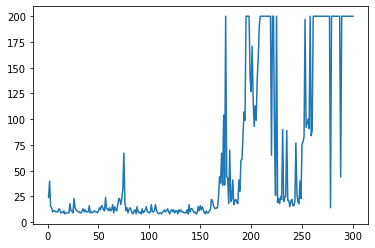

In [67]:
train_cartpole(0,300)

Episode: 150, reward: 150.0, length: 150
Episode: 300, reward: 300.0, length: 300
Episode: 450, reward: 450.0, length: 450
Episode: 600, reward: 600.0, length: 600
Episode: 750, reward: 750.0, length: 750
Episode: 900, reward: 898.0, length: 900
Episode: 1050, reward: 1048.0, length: 1050
Episode: 1200, reward: 1198.0, length: 1200
Episode: 1350, reward: 1348.0, length: 1350
Episode: 1500, reward: 1498.0, length: 1500
Episode: 1650, reward: 1648.0, length: 1650
Episode: 1800, reward: 1798.0, length: 1800
Episode: 1950, reward: 1948.0, length: 1950
Episode: 2100, reward: 2098.0, length: 2100
Episode: 2250, reward: 2248.0, length: 2250
Episode: 2400, reward: 2398.0, length: 2400
Episode: 2550, reward: 2548.0, length: 2550
Episode: 2700, reward: 2698.0, length: 2700
Episode: 2850, reward: 2848.0, length: 2850
Episode: 3000, reward: 2998.0, length: 3000
Episode: 3150, reward: 3148.0, length: 3150
Episode: 3300, reward: 3298.0, length: 3300
Episode: 3450, reward: 3448.0, length: 3450
Episod

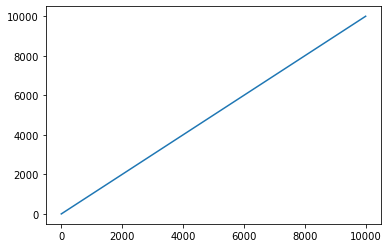

In [68]:
def test_cartpole(policy: ActorCriticNetwork):
    test_env = gym.make(environment_name)
    state = test_env.reset()

    episode_count = 0
    episode_reward = 0

    max_iteration = 10000

    is_done = False

    iterations, rewards = [], []



    while True:
        episode_count += 1
        if episode_count  > max_iteration:
            break

        wrapper = policy(torch.Tensor([state]))
        action = wrapper.action_tensors.item()

        next_state, reward, is_done , _ = test_env.step(action)

        episode_reward += reward

        iterations.append(episode_count)
        rewards.append(episode_reward)

        if is_done and episode_count < 200 :
            break
        
        state = next_state

        if episode_count % 150 == 0:
            print(f"Episode: {episode_count}, reward: {episode_reward}, length: {episode_count}")

    plt.plot(iterations,rewards)

test_cartpole(ac_model)
            


In [69]:
from torch import nn
torch.manual_seed(42)
#torch.seed()

class PolicyNetwork(nn.Module):
    def __init__(self, input_nodes: int, hidden_nodes: int, output_nodes: int ):
        super(PolicyNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, output_nodes),
            nn.ReLU(),
            nn.Softmax(dim=1)
            #nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        result = self.network(input)
        return result

policy_network = PolicyNetwork(4, 128, 2)
network_output = policy_network.forward(torch.Tensor([[1,2,3,4], [4,7,9,2]]))

print("Output size: ", network_output.size(-1) )
print("Network output: ", network_output )
print("Squeeze: ",  network_output.squeeze() )
print("*******")

prob_dist = torch.distributions.Categorical(network_output)
sampling_result = prob_dist.sample()

print("Sampling from prob distribution: ", sampling_result )
print("??", sampling_result.unsqueeze(dim=1))

z = sampling_result.unsqueeze(dim=1)
x = z.squeeze(dim=1)
print("X", x)

sampled_probs = network_output.gather(1, sampling_result.unsqueeze(dim=1) )
print("Gather: ", sampled_probs )
print("Log Sampled: ", torch.log(sampled_probs))

log_probs = prob_dist.log_prob(sampling_result)

print("Sampling log prob: ", log_probs)

#network_output.gather(1, torch.LongTensor([[0],[1]]) )

Output size:  2
Network output:  tensor([[0.4933, 0.5067],
        [0.0969, 0.9031]], grad_fn=<SoftmaxBackward0>)
Squeeze:  tensor([[0.4933, 0.5067],
        [0.0969, 0.9031]], grad_fn=<SqueezeBackward0>)
*******
Sampling from prob distribution:  tensor([0, 1])
?? tensor([[0],
        [1]])
X tensor([0, 1])
Gather:  tensor([[0.4933],
        [0.9031]], grad_fn=<GatherBackward0>)
Log Sampled:  tensor([[-0.7066],
        [-0.1019]], grad_fn=<LogBackward0>)
Sampling log prob:  tensor([-0.7066, -0.1019], grad_fn=<SqueezeBackward1>)
